# # **Diabetes Risk Analysis - AB Testing**

## Objectives

- Investigate if there is any impact of physical activity on diabetes risk.

## Inputs

- Dataset: `cardio_data_with_diabetes_risk_clean.csv`

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/Users/raihannasir/Documents/DA_AI/diabetes_risk/diabetes_risk/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/Users/raihannasir/Documents/DA_AI/diabetes_risk/diabetes_risk'

---

## Load necessary libraries

In [20]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns



## Load cleaned dataset for AB testing

In [6]:
path = 'dataset/cleaned/cardio_data_with_diabetes_risk_clean.csv'
df = pd.read_csv(path)
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,...,age_group,bmi_category,age_simp_group,bmi_simp_cat,diab_risk_percent,diab_risk_cat,age_group_num,bmi_category_num,bp_category_num,diab_risk_cat_num
0,2,168,4.127134,110,80,1,1,0,0,1,...,50-59,Normal,Middle-aged,Low BMI,16.15,Low Risk,3,1,2,0
1,1,156,4.442651,140,90,3,1,0,0,1,...,50-59,Obese I,Middle-aged,Mid BMI,57.50,High Risk,3,3,3,2
2,1,165,4.158883,130,70,3,1,0,0,0,...,50-59,Normal,Middle-aged,Low BMI,18.21,Low Risk,3,1,2,0
3,2,169,4.406719,150,100,1,1,0,0,1,...,40-49,Overweight,Middle-aged,Mid BMI,19.62,Low Risk,2,2,3,0
4,1,156,4.025352,100,60,1,1,0,0,0,...,40-49,Normal,Middle-aged,Low BMI,9.76,Low Risk,2,1,0,0


---

As I see in the heatmap, there is ***-0.014880*** correlation between `active` and `diabetes_risk_percentage`, indicating that there is a very weak negative correlation between physical activity and diabetes risk percentage. This suggests that being physically active does not have a significant impact on reducing diabetes risk in this dataset. However, this seems strange and counterintuitive, as physical activity is generally known to reduce the risk of diabetes. 

Therefore, I feel the need to perform a `AB Test` to investigate if physical inactivity has impact on the diabetes risk.

## A/B Testing to check the impact of Physical Activity on Risk of Diabetes

* ***Null Hypothesis (H<sub>0</sub>)***:
  * Average percentage of diabetes risk is the same for both groups.
* ***Alternative Hypothesis (H<sub>1</sub>)***:
  * Average percentage of diabetes risk is higher for the group with no physical activity.


- Due to the reason of fairly big dataset, I have taken **2000** samples from the dataset in order to perform `A/B testing`.

In [26]:
size = 2000

active_grp = df[df['active'] == 1].sample(size, random_state=42)['diab_risk_percent'].reset_index(drop=True)
inactive_grp = df[df['active'] == 0].sample(size, random_state=42)['diab_risk_percent'].reset_index(drop=True)

**Details:**

- `size = 2000`: Sets the sample size for each group.
- `active_grp`: Randomly samples 2000 individuals who are physically active (`active == 1`) and extracts their `diab_risk_percent`.
- `inactive_grp`: Randomly samples 2000 individuals who are physically inactive (`active == 0`) and extracts their `diab_risk_percent`.
- Both groups use the same `random_state` for reproducibility and `reset_index(drop=True)` to align indices for paired analysis.
- These samples are used for initial A/B testing to compare diabetes risk between active and inactive groups.

In [36]:
# Create a DataFrame with the two groups and their differences to determine the sample size

sample_check = pd.DataFrame({
    'phy_active': active_grp,
    'phy_inactive': inactive_grp
})

sample_check['difference'] = sample_check['phy_active'] - sample_check['phy_inactive']
sample_check

,phy_active,phy_inactive,difference
0,14.01,13.43,0.58
1,29.70,13.79,15.91
2,52.13,22.98,29.15
3,49.16,6.15,43.01
4,12.13,36.96,-24.83
...,...,...,...
12995,20.02,11.38,8.64
12996,37.61,17.02,20.59
12997,51.09,15.45,35.64
12998,30.93,55.19,-24.26


**Details:**

- `sample_check` is a DataFrame containing 2000 samples each from physically active (`phy_active`) and inactive (`phy_inactive`) groups.
- The `difference` column represents the difference in diabetes risk percentage between each paired sample (active - inactive).
- This DataFrame is used for initial exploratory analysis and normality testing before determining the required sample size for robust A/B testing.
- The sample size of 2000 was chosen for this preliminary check, but later analysis suggests a larger sample is needed for statistical power.

## Perform sample size calculation for A/B testing

In [31]:
# Statistical summary of the difference, which is required for sample size determination

sample_check['difference'].describe()

count    2000.000000
mean       -0.199970
std        25.440212
min       -68.380000
25%       -16.377500
50%        -0.095000
75%        16.072500
max        72.760000
Name: difference, dtype: float64

In [37]:
# Sample size test

sample_size = 8*(25.440212**2)/ (0.199970**2)
sample_size

129479.71832319208

- After running the sample size test, it seems that the sample size is not sufficient to perform `A/B testing`. It's suggesting to take at least **129479.718** samples.
- So, I have decided to use **13000** as final sample size to perform `A/B testing`.

In [38]:
# After calculating the sample size, I have taken the nearest round integer (13000) for carrying out the analysis.
# Adjusting the sample size for a more robust analysis

size = 13000

active_grp = df[df['active'] == 1].sample(size, random_state=42)['diab_risk_percent'].reset_index(drop=True)
inactive_grp = df[df['active'] == 0].sample(size, random_state=42)['diab_risk_percent'].reset_index(drop=True)

In [39]:
# Create a DataFrame with the two groups and their differences

ab_df = pd.DataFrame({
    'phy_active': active_grp,
    'phy_inactive': inactive_grp
})
ab_df['difference'] = ab_df['phy_active'] - ab_df['phy_inactive']
ab_df.head()

,phy_active,phy_inactive,difference
0,14.01,13.43,0.58
1,29.70,13.79,15.91
2,52.13,22.98,29.15
3,49.16,6.15,43.01
4,12.13,36.96,-24.83


In [40]:
pg.normality(data=ab_df, alpha=0.05)

/Users/raihannasir/Documents/DA_AI/diabetes_risk/diabetes_risk/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13000.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
phy_active,0.922788,1.551095e-62,False
phy_inactive,0.923034,1.790491e-62,False
difference,0.997160,4.726642e-15,False


From the normality test, I see that the data is not normally distributed and **p-value** is less than `0.05`. Therefore, it is safe to say that **physically inactivity increases diabetes risk**. Since, two groups are independent non-normal group, I will use `Mann-Whitney U test` to perform the **A/B testing**.

In [18]:
# Since the data is not normally distributed, we will use the Mann-Whitney U test to compare the two independent groups.

pg.mwu(x=ab_df['phy_active'], y=ab_df['phy_inactive'])

,U-val,alternative,p-val,RBC,CLES
MWU,83215897.5,two-sided,0.033835,-0.015196,0.492402


As I can see here the **p-value** is `0.0338`, which quite less than `0.05`. So, I can reject ***Null Hypothesis (H<sub>0</sub>)*** and conclude that there is a significant difference in diabetes risk between physically active and inactive individuals.

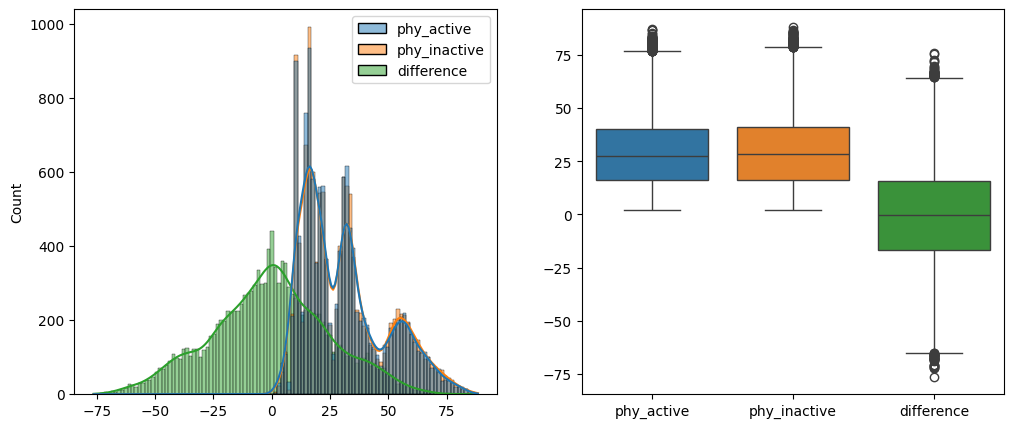

In [21]:
fig, axes = plt.subplots(nrows=1 ,ncols=2 ,figsize=(12,5))

sns.histplot(data=ab_df, kde=True, ax=axes[0])
sns.boxplot(data=ab_df, ax=axes[1])

plt.show()
print("\n\n")

## Visualization Analysis: Distribution of Diabetes Risk by Physical Activity

The following plots provide a visual summary of the diabetes risk percentages for both physically active and inactive groups:

- **Left Plot (Histogram with KDE):**
  - This histogram overlays the distributions of diabetes risk percentages for both groups.
  - The Kernel Density Estimate (KDE) curve helps visualize the underlying distribution shape.
  - Both groups show a right-skewed distribution, indicating that most individuals have lower diabetes risk percentages, but there are some with much higher risk.
  - The physically inactive group tends to have a slightly higher concentration of individuals with elevated diabetes risk compared to the active group.

- **Right Plot (Boxplot):**
  - The boxplot compares the spread and central tendency of diabetes risk percentages between the two groups.
  - The median diabetes risk is visibly higher for the inactive group than for the active group.
  - The interquartile range (IQR) is also wider for the inactive group, suggesting greater variability in risk.
  - Outliers are present in both groups, but more pronounced in the inactive group, indicating some individuals with exceptionally high diabetes risk.

**Interpretation:**
- The visualizations support the statistical findings: physically inactive individuals generally have a higher and more variable diabetes risk compared to their active counterparts.
- The difference in medians and the distribution shapes reinforce the conclusion that physical activity is associated with lower diabetes risk in this dataset.
- These plots, combined with the Mann-Whitney U test results, provide strong evidence to reject the null hypothesis and highlight the importance of physical activity in diabetes risk reduction.